<a href="https://colab.research.google.com/github/santiagorg2401/tensorflow_course_exercises/blob/main/04_TransferLearning_01_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow part 1: Feature Extraction.

## Helper functions.

In [1]:
# Plot validation ans training curves separately.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

def view_random_image(target_dir, target_class, i=1):
  """
  Get a random image path, read it and plot it.
  target_dir: String. It contains the target directory where the iamges are stored.
  target_class: String. The class name of the image to plot.

  i: Integer. Number of images to retrieve.
  """
  # Setup the targer directory.
  target_folder = target_dir + target_class

  imgs = []

  for j in range(0,i):
    # Get a random image path.
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    # Read in the image and plot it.
    img  = mpimg.imread(target_folder + "/" + random_image[0])
    fig, (ax) = plt.subplots()
    ax.imshow(img)
    ax.set_title(target_class)
    ax.set_axis_off()
    print(f"Image shape: {img.shape}")
    imgs.append(img)

  plt.show()
  return img

def load_and_prep_img(filename, img_shape=(224,224)):
  """
  Reads an image from `filename`, turns into a tensor and reshapes it.
  """

  # Read in the image.
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor.
  img = tf.image.decode_image(img)

  # Resize the image.
  img = tf.image.resize(img, size=img_shape)

  # Rescale the image.
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  """
  Makes a prediction based on a filename and plots it.

  Keyword arguments:
  model -- TensorFlow model.
  filename -- String, contains file path to input image.
  class_names -- List, contains class names.
  """

  # Import image and preprocess it.
  img = load_and_prep_img(filename)

  # Make a prediction.
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class for multi-class and binary classification..
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot image and predicted class as title.
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_HubModel(model_url, num_classes, IMG_SIZE):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be 
      equal to number of target classes.
  
  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor layer
  and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer without training.
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SIZE + (3,))
  
  # Create the model.
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model


## Import and become one with the data.

In [3]:
# Unzip data.
import zipfile
import os

try:
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
  zip_ref.extractall()
  zip_ref.close()
except:
  print("File not found, downloading and trying again.")
  # Download dataset.
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
  zip_ref.extractall()
  zip_ref.close()

# Get familiar with class names.
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

File not found, downloading and trying again.
/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2022-12-13 15:46:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.172.16, 172.217.173.48, 142.250.78.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.172.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  30.5MB/s    in 5.1s    

2022-12-13 15:46:23 (31.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_foo

In [4]:
import pathlib
import numpy as np

# Setup the train and test directories.
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Set hyperparameters.
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Get class names.
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


['3020415.jpg']
Image shape: (512, 512, 3)
['1316112.jpg']
Image shape: (512, 512, 3)


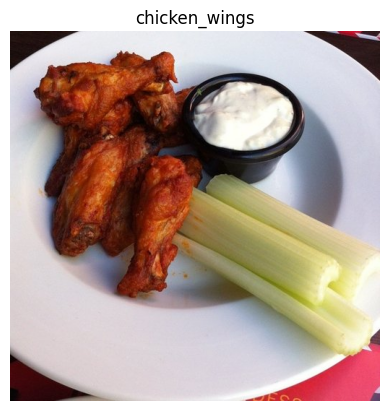

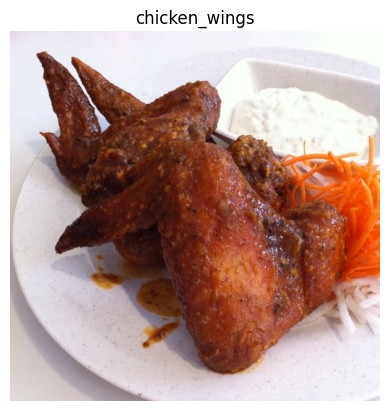

['504131.jpg']
Image shape: (512, 512, 3)
['1967445.jpg']
Image shape: (512, 512, 3)


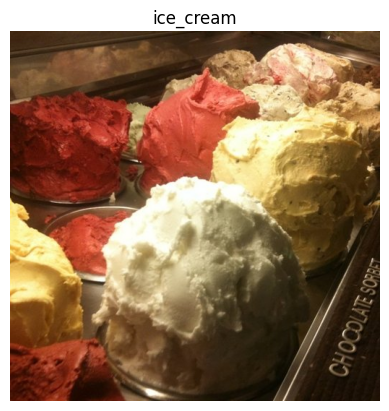

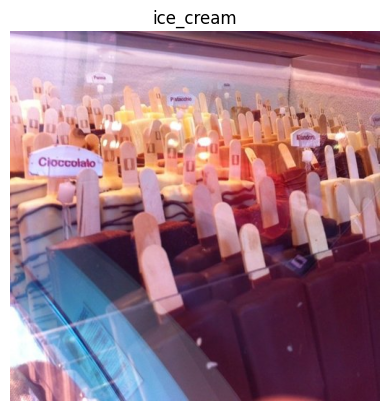

In [5]:
# Visualize.
import random
img = view_random_image(target_dir=train_dir,
                        target_class='chicken_wings',
                        i=2)

img = view_random_image(target_dir=train_dir,
                        target_class='ice_cream',
                        i=2)

## Set up callbacks.

In [6]:
import datetime

# Create tensorboard callback.
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}.")
  return tensorboard_callback



## `resnet_model` ResNet50V2 TensorFlow Hub.
Use TensorFlow hub to download trained ML models.
https://tfhub.dev/
Using feature extraction, change only output layer.

### 1. Preprocess the data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale.
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load in from directories and turn it into batches.
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 2. Create the model.

In [8]:
import tensorflow as tf

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Check physical devices for GPU.
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Build the model.
resnet_model = create_HubModel(model_url=resnet_url,
                               num_classes=train_data.num_classes,
                               IMG_SIZE=IMG_SIZE)

# Compile the model.
resnet_model.compile(loss=["categorical_crossentropy"],
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Fit the model.
history_resnet_model = resnet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="models/04-TransferLearning-01/tensorflow_hub",
                                                                               experiment_name="resnet50V2")])

resnet_model.summary()

Num GPUs: 1


2022-12-13 15:46:47.095429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 15:46:47.115843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 15:46:47.116565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 15:46:51.027712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Saving TensorBoard log files to: models/04-TransferLearning-01/tensorflow_hub/resnet50V2/20221213-154652.
Epoch 1/5


2022-12-13 15:46:54.982355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-13 15:46:55.509633: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-13 15:46:55.509983: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-13 15:46:55.510000: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-13 15:46:55.510369: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-13 15:46:55.510417: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 1/24 [>.............................] - ETA: 1:38 - loss: 3.0344 - accuracy: 0.1875

2022-12-13 15:46:56.773883: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - 13s 369ms/step - loss: 1.8569 - accuracy: 0.3813 - val_loss: 1.1508 - val_accuracy: 0.6556
Epoch 2/5
24/24 [==============================] - 7s 308ms/step - loss: 0.9057 - accuracy: 0.7240 - val_loss: 0.8403 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 7s 304ms/step - loss: 0.6181 - accuracy: 0.8227 - val_loss: 0.7493 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 7s 305ms/step - loss: 0.4754 - accuracy: 0.8760 - val_loss: 0.6875 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 7s 304ms/step - loss: 0.3793 - accuracy: 0.9200 - val_loss: 0.6650 - val_accuracy: 0.7820
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                    

### 3. Evaluate the model.

In [9]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6650 - accuracy: 0.7820


[0.6650437116622925, 0.7820000052452087]

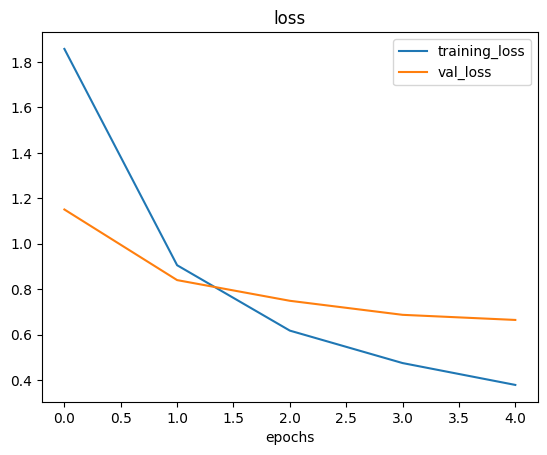

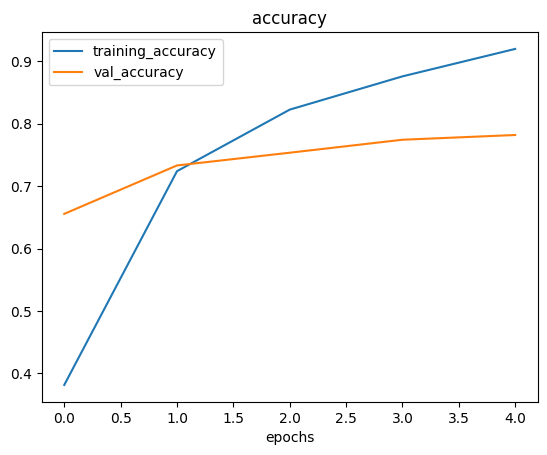

In [10]:
plot_loss_curves(history_resnet_model)

### 4. Make predictions.

1/1 [==============================] - 1s 765ms/step


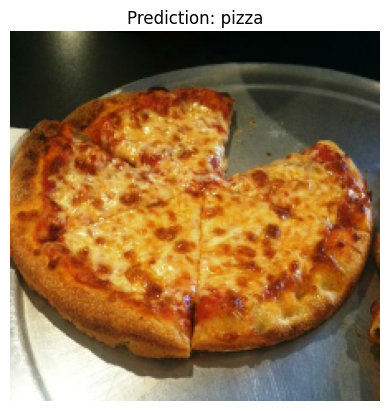

In [12]:
pred_and_plot(resnet_model, "images/pizza.jpg", class_names)

1/1 [==============================] - 0s 16ms/step


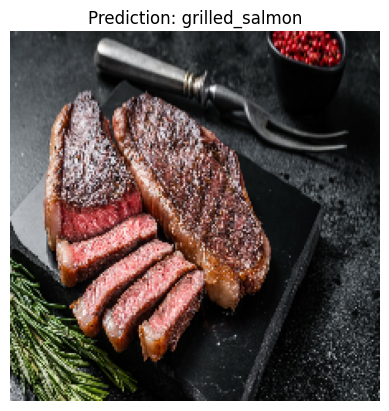

In [13]:
pred_and_plot(resnet_model, "images/steak.jpg", class_names)

1/1 [==============================] - 0s 23ms/step


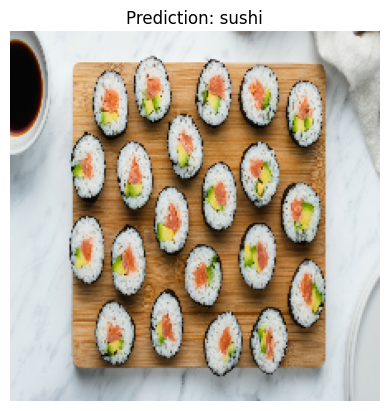

In [14]:
pred_and_plot(resnet_model, "images/sushi.jpg", class_names)

## `efficientnet_model` EfficientNetB0 TensorFlow Hub.
Use TensorFlow hub to download trained ML models.
https://tfhub.dev/
Using feature extraction, change only output layer.

### 1. Preprocess the data.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale.
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load in from directories and turn it into batches.
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 2. Create the model.
From TF Hub efficientnet/b0/feature-vector.

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [24]:
import tensorflow as tf

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Check physical devices for GPU.
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Build the model.
efficientnet_model = create_HubModel(model_url=efficientnet_url, 
                               num_classes=train_data.num_classes, 
                               IMG_SIZE=IMG_SIZE)

# Compile the model.
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Fit the model.
history_efficientnet_model = efficientnet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="models/04-TransferLearning-01/tensorflow_hub",
                                                                              experiment_name="efficientnet")])

efficientnet_model.summary()

Num GPUs: 1
Saving TensorBoard log files to: models/04-TransferLearning-01/tensorflow_hub/efficientnet/20221213-155205.
Epoch 1/5
24/24 [==============================] - 12s 280ms/step - loss: 1.9131 - accuracy: 0.3880 - val_loss: 1.3383 - val_accuracy: 0.7300
Epoch 2/5
24/24 [==============================] - 5s 218ms/step - loss: 1.0838 - accuracy: 0.7787 - val_loss: 0.8876 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 5s 220ms/step - loss: 0.7691 - accuracy: 0.8307 - val_loss: 0.7111 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 5s 218ms/step - loss: 0.6197 - accuracy: 0.8640 - val_loss: 0.6213 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 5s 219ms/step - loss: 0.5287 - accuracy: 0.8867 - val_loss: 0.5680 - val_accuracy: 0.8588
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_

### 3. Evaluate the model.

In [25]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 0.5680 - accuracy: 0.8588


[0.5679681301116943, 0.8587999939918518]

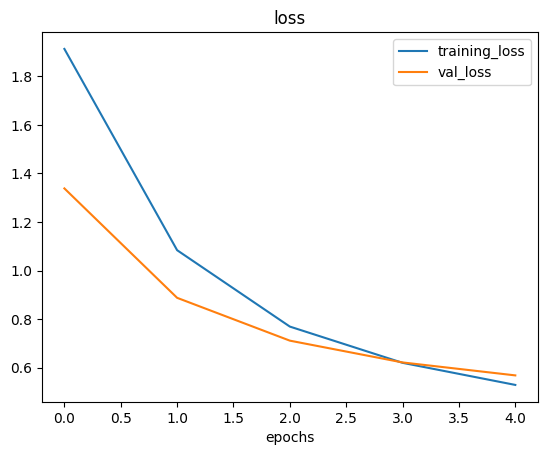

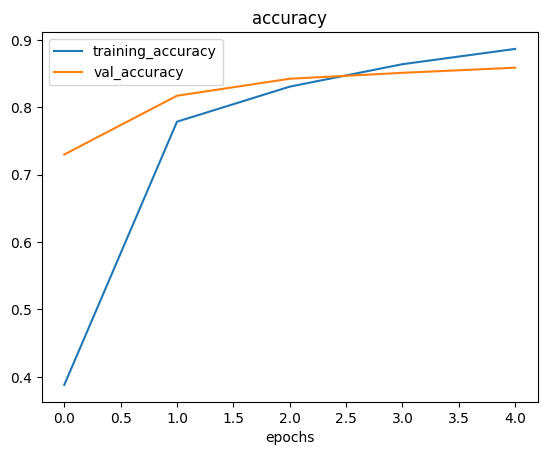

In [26]:
plot_loss_curves(history_efficientnet_model)

### 4. Make predictions.

1/1 [==============================] - 1s 1s/step


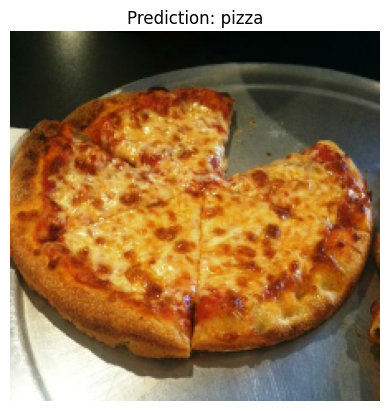

In [27]:
pred_and_plot(efficientnet_model, "images/pizza.jpg", class_names)

1/1 [==============================] - 0s 23ms/step


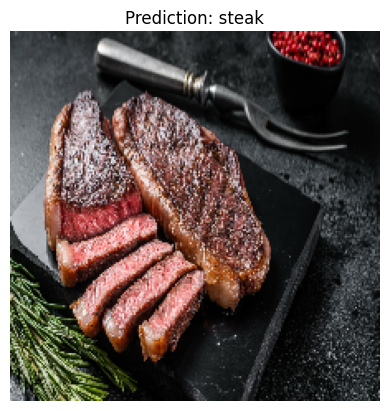

In [28]:
pred_and_plot(efficientnet_model, "images/steak.jpg", class_names)

1/1 [==============================] - 0s 25ms/step


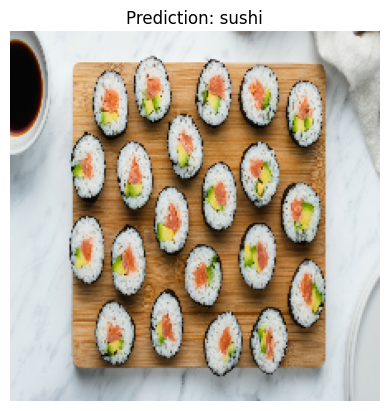

In [29]:
pred_and_plot(efficientnet_model, "images/sushi.jpg", class_names)

## Compare model results with TensorBoard.
tensorboard.dev

Do not upload private data here.

In [35]:
!tensorboard dev upload --logdir /models/04-TransferLearning-01/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of training data" \
  --one_shot

/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2022-12-13 17:44:36.322300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 17:44:36.325488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 17:44:36.325623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/models/04-TransferLearning-01/: No such directory.
User specified `one_shot` mode with an unavailable logdir. Exiting without creating an experiment.


Upload made locally, cell left for the record.

URL = https://tensorboard.dev/experiment/99kZXQhxTbipTqP2orUk2w/#scalars